In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


In [66]:
# Read the evaluation dataframe
df = pd.read_csv('df_text_eval.csv')

print(f"Shape: {df.shape}")
df.head()


Shape: (1885, 54)


,index,text,text_len,text_words,vic_grupo_social,amenaza_quien,captura_metodo,captura_tipo,cautiverio_trato,desenlace,...,desenlace_match,desenlace_tipo_match,perp_tipo1_match,perp_tipo2_match,proced_contacto1_match,proced_contacto2_match,proced_contactado_match,Tribunal_tipo_match,proced_sent_tipo_match,soc_civil_match
0,Guerrero_Abel A G_1,Abel soñaba ser ingeniero y dejó su pueblo. Se...,5511,894,Students,NaN,Disappearance,"Places related to the victim (house, workplace...",NaN,Still disappeared,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,Guerrero_Abel A G_5,"Policía de Chilpancingo, involucrada en desapa...",5071,827,Students,NaN,Disappearance,"Places related to the victim (house, workplace...",NaN,Still disappeared,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
2,Guerrero_Abel A G_7,N+ Noticias: De México y el Mundo | N+ En Vivo...,15788,2556,Students,NaN,Disappearance,"Places related to the victim (house, workplace...",NaN,Still disappeared,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,Guerrero_Abel A G_3,--> Desaparición forzada en Chilpancingo ¿Otro...,7636,1122,Students,NaN,Disappearance,"Places related to the victim (house, workplace...",NaN,Still disappeared,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,Guerrero_Abel A G_4,Familiares de desaparecidos temen impunidad en...,3442,507,Students,NaN,Disappearance,"Places related to the victim (house, workplace...",NaN,Still disappeared,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [67]:
# Aggregate scores for geval_* and summac_* metrics
metrics = {
    'geval_summarization': df['geval_summarization_score'].mean(),
    'geval_hallucination': df['geval_hallucination_score'].mean(),
    'summac_zs': df['summac_zs_score'].mean(),
    'summac_conv': df['summac_conv_score'].mean()
}

metrics


{'geval_summarization': 0.14118972697228144,
 'geval_hallucination': 0.10793202268385586,
 'summac_zs': 0.026847079732654863,
 'summac_conv': 0.33502668481843856}

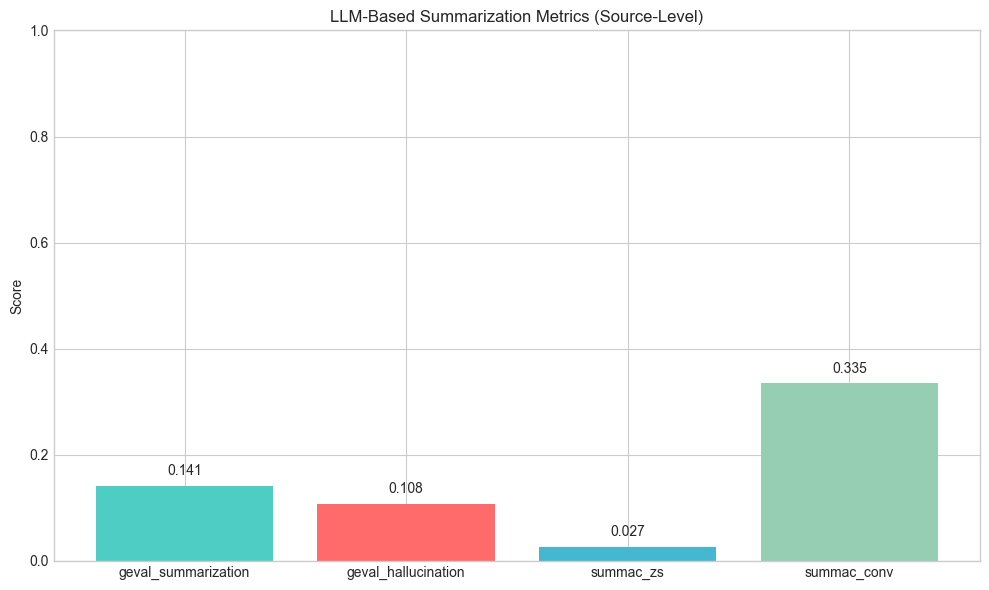

In [68]:
# Bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics.keys(), metrics.values(), color=['#4ecdc4', '#ff6b6b', '#45b7d1', '#96ceb4'])
ax.set_ylabel('Score')
ax.set_title('LLM-Based Summarization Metrics (Source-Level)')
ax.set_ylim(0, 1)

for bar, val in zip(bars, metrics.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center')

plt.tight_layout()
plt.savefig('plots/metrics_llm_summarization.png', dpi=150, bbox_inches='tight')
plt.show()


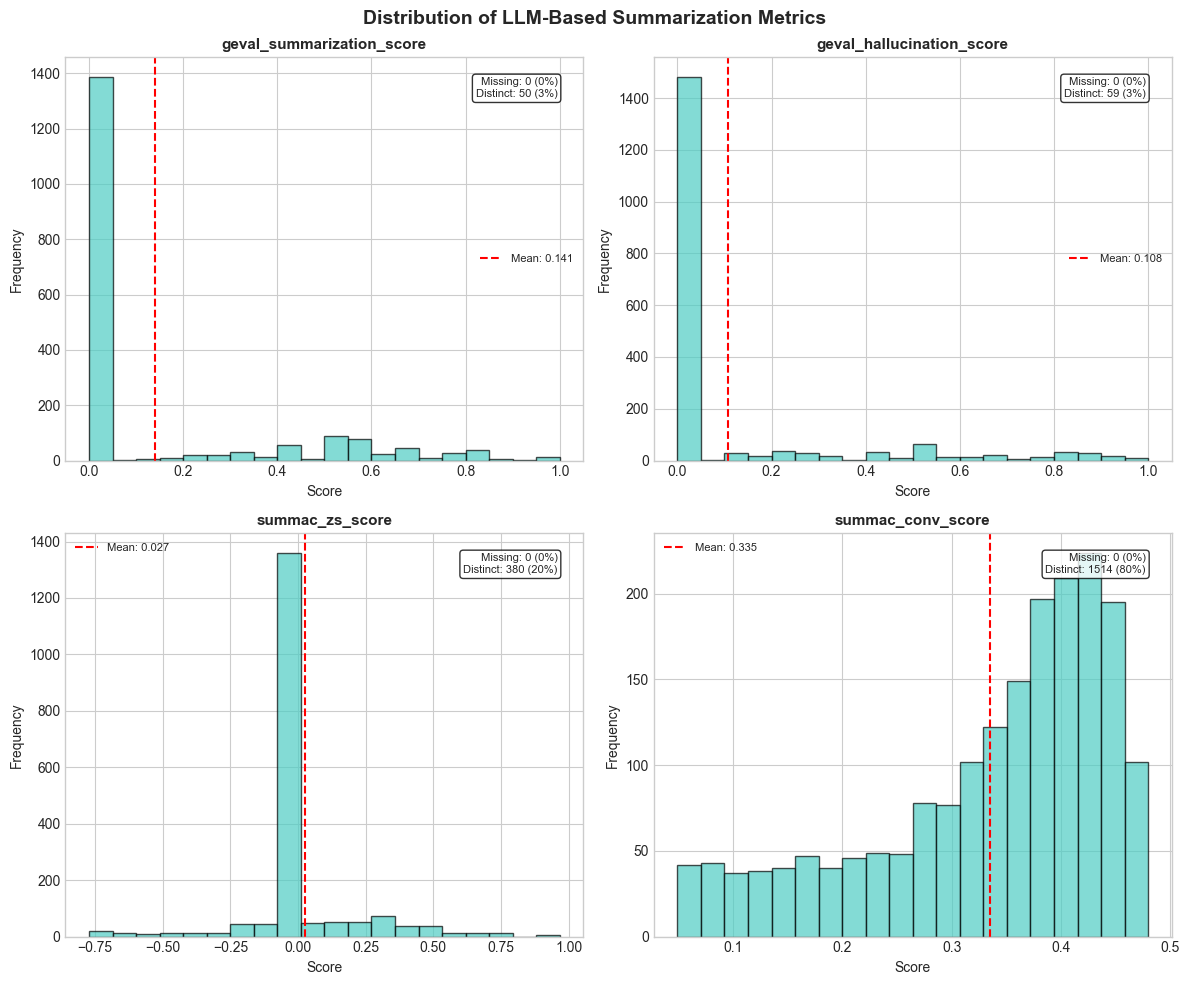

In [69]:
# Distribution of LLM-based metrics
score_cols = ['geval_summarization_score', 'geval_hallucination_score', 'summac_zs_score', 'summac_conv_score']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, col in enumerate(score_cols):
    ax = axes[idx]
    data = df[col].dropna()
    
    ax.hist(data, bins=20, color='#4ecdc4', edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    
    # Add stats
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
    ax.legend(fontsize=8)
    
    # Add missing/distinct info
    ax.text(0.95, 0.95, f'Missing: {df[col].isna().sum()} ({df[col].isna().mean()*100:.0f}%)\nDistinct: {data.nunique()} ({data.nunique()/len(data)*100:.0f}%)',
            transform=ax.transAxes, ha='right', va='top', fontsize=8, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Distribution of LLM-Based Summarization Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/metrics_llm_summarization_dist.png', dpi=150, bbox_inches='tight')
plt.show()


In [70]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
import numpy as np

# Define the label mapping (human annotation -> machine classification)
labelling_map = {
    'vic_grupo_social': 'vic_grupo_social_classification',
    'amenaza_quien': 'amenaza_quien_classification',
    'captura_metodo': 'captura_metodo_classification',
    'captura_tipo': 'captura_tipo_classification',
    'cautiverio_trato': 'cautiverio_trato_classification',
    'desenlace': 'desenlace_classification',
    'desenlace_tipo': 'desenlace_tipo_classification',
    'perp_tipo1': 'perp_tipo1_classification',
    'perp_tipo2': 'perp_tipo2_classification',
    'proced_contacto1': 'proced_contacto1_classification',
    'proced_contacto2': 'proced_contacto2_classification',
    'proced_contactado': 'proced_contactado_classification',
    'Tribunal_tipo': 'Tribunal_tipo_classification',
    'proced_sent_tipo': 'proced_sent_tipo_classification',
    'soc_civil': 'soc_civil_classification'
}

# Calculate metrics for each label
label_metrics = {}

for human_col, machine_col in labelling_map.items():
    # Get valid rows (both columns have values)
    mask = df[human_col].notna() & df[machine_col].notna()
    human_vals = df.loc[mask, human_col].fillna('').astype(str)
    machine_vals = df.loc[mask, machine_col].fillna('').astype(str)
    
    if len(human_vals) > 0:
        acc = accuracy_score(human_vals, machine_vals)
        f1 = f1_score(human_vals, machine_vals, average='macro', zero_division=0)
        kappa = cohen_kappa_score(human_vals, machine_vals)
        
        label_metrics[human_col] = {
            'Accuracy': acc,
            'F1 (macro)': f1,
            'Cohen Kappa': kappa
        }

# Convert to DataFrame for easy viewing
metrics_df = pd.DataFrame(label_metrics).T
metrics_df


,Accuracy,F1 (macro),Cohen Kappa
vic_grupo_social,0.515982,0.238420,0.422697
amenaza_quien,0.375000,0.206572,0.176672
captura_metodo,0.460606,0.211593,0.183136
captura_tipo,0.198649,0.103607,0.057639
cautiverio_trato,0.552632,0.242790,0.229117
desenlace,0.705376,0.338171,0.482797
desenlace_tipo,0.220544,0.145180,0.117215
perp_tipo1,0.307692,0.158010,0.242545
perp_tipo2,0.104895,0.055917,0.042478
proced_contacto1,0.595122,0.078943,0.092960


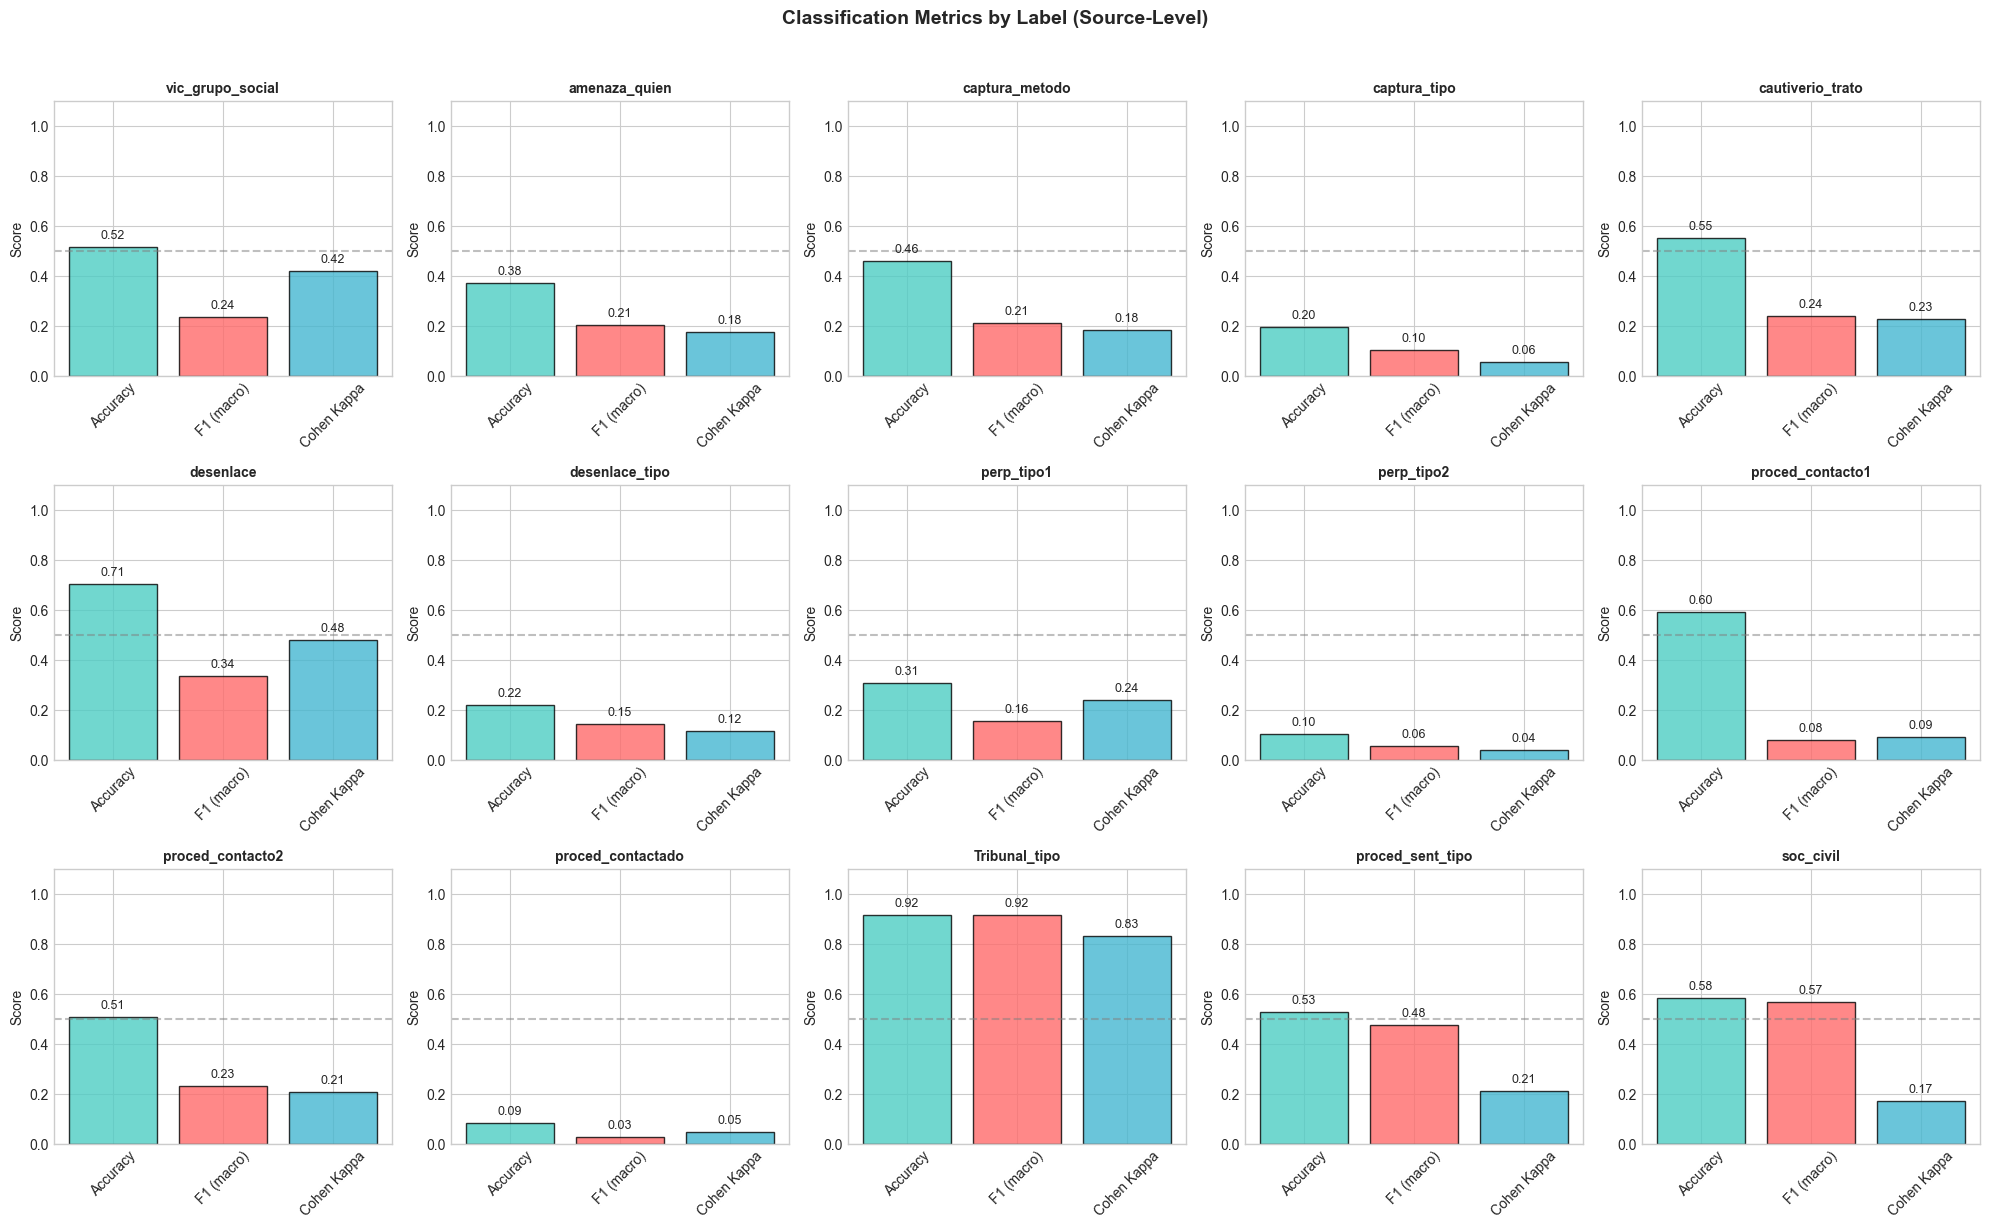

In [71]:
# Create matrix of plots - one subplot per label
n_labels = len(label_metrics)
n_cols = 5
n_rows = (n_labels + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

metric_names = ['Accuracy', 'F1 (macro)', 'Cohen Kappa']
colors = ['#4ecdc4', '#ff6b6b', '#45b7d1']

for idx, (label_name, metrics_dict) in enumerate(label_metrics.items()):
    ax = axes[idx]
    values = [metrics_dict[m] for m in metric_names]
    
    bars = ax.bar(metric_names, values, color=colors, edgecolor='black', alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylim(0, 1.1)
    ax.set_title(label_name, fontsize=10, fontweight='bold')
    ax.set_ylabel('Score')
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=45)

# Hide empty subplots
for idx in range(len(label_metrics), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Classification Metrics by Label (Source-Level)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/metrics_per_label_source.png', dpi=150, bbox_inches='tight')
plt.show()


In [72]:
# Convert per-source to per-victim with consensus labels

# 1. Extract victim from index (Region_Name_Number → Region_Name)
def extract_victim(idx):
    parts = idx.rsplit('_', 1)
    return parts[0] if len(parts) == 2 and parts[1].isdigit() else idx

df['victim'] = df['index'].apply(extract_victim)

# 2. Define human and machine label columns
human_label_cols = list(labelling_map.keys())
machine_label_cols = list(labelling_map.values())
all_label_cols = human_label_cols + machine_label_cols

# 3. Consensus function (mode)
def consensus(s):
    v = s.dropna()
    return v.mode().iloc[0] if len(v) and len(v.mode()) else None

# 4. Aggregate by victim - consensus for both human and machine labels
agg = {c: consensus for c in all_label_cols if c in df.columns}
df_victim = df.groupby('victim', as_index=False).agg(agg)

print(f"{len(df)} source rows → {len(df_victim)} victims")
df_victim.head()


1885 source rows → 545 victims


,victim,vic_grupo_social,amenaza_quien,captura_metodo,captura_tipo,cautiverio_trato,desenlace,desenlace_tipo,perp_tipo1,perp_tipo2,...,desenlace_classification,desenlace_tipo_classification,perp_tipo1_classification,perp_tipo2_classification,proced_contacto1_classification,proced_contacto2_classification,proced_contactado_classification,Tribunal_tipo_classification,proced_sent_tipo_classification,soc_civil_classification
0,Coahuila_Agustin Alberto N M,People that work in service industries (taxi d...,None,Levantón (kidnapping but pejorative use toward...,None,None,Still disappeared,None,Army,None,...,Still disappeared,"Authorities (government offices, military faci...",Organized crime (name is unspecified),Organized crime (name is unspecified),Relatives,Relatives,None,Federal,Condemnatory,No
1,Coahuila_Agustin H G,People that work in service industries (taxi d...,None,Disappearance,None,None,Still disappeared,None,None,None,...,Still disappeared,Means and routes of transport and places of co...,State agent (press article does not specify mo...,None,Relatives,Relatives,Fiscalía General del Estado (FGE),State,Condemnatory,No
2,Coahuila_Alberto G H,People that work in service industries (taxi d...,None,Disappearance,None,None,Still disappeared,None,None,None,...,Still disappeared,"Economic, social, industrial, agricultural and...",None,None,Relatives,Relatives,Prosecutor,State,None,Yes (explain more in the final comments section)
3,Coahuila_Antonio H H,None,None,Disappearance,None,None,Still disappeared,None,None,None,...,Still disappeared,"Economic, social, industrial, agricultural and...",None,None,Neighbors,None,District attorney’s office,None,None,No
4,Coahuila_Antonio de Jesus M R,Other,None,Disappearance,None,None,Found alive,"Economic, social, industrial, agricultural and...",None,None,...,Still disappeared,"Authorities (government offices, military faci...",None,None,Relatives,Relatives,Municipal police,None,None,No


In [73]:
# Calculate per-victim metrics for each label
label_metrics_victim = {}

for human_col, machine_col in labelling_map.items():
    if human_col not in df_victim.columns or machine_col not in df_victim.columns:
        continue
        
    # Get valid rows (both columns have values)
    mask = df_victim[human_col].notna() & df_victim[machine_col].notna()
    human_vals = df_victim.loc[mask, human_col].fillna('').astype(str)
    machine_vals = df_victim.loc[mask, machine_col].fillna('').astype(str)
    
    if len(human_vals) > 0:
        acc = accuracy_score(human_vals, machine_vals)
        f1 = f1_score(human_vals, machine_vals, average='macro', zero_division=0)
        kappa = cohen_kappa_score(human_vals, machine_vals)
        
        label_metrics_victim[human_col] = {
            'Accuracy': acc,
            'F1 (macro)': f1,
            'Cohen Kappa': kappa
        }

# Convert to DataFrame for easy viewing
metrics_victim_df = pd.DataFrame(label_metrics_victim).T
print(f"Victim-level metrics (n={len(df_victim)} victims)")
metrics_victim_df


Victim-level metrics (n=545 victims)


,Accuracy,F1 (macro),Cohen Kappa
vic_grupo_social,0.446352,0.284849,0.351899
amenaza_quien,0.384615,0.330556,0.161290
captura_metodo,0.532300,0.195133,0.226760
captura_tipo,0.169565,0.084846,0.034824
cautiverio_trato,0.565217,0.400794,0.258065
desenlace,0.731118,0.378657,0.508049
desenlace_tipo,0.152174,0.108824,0.069381
perp_tipo1,0.339744,0.188553,0.273139
perp_tipo2,0.094340,0.044545,0.010502
proced_contacto1,0.604895,0.120813,0.118392


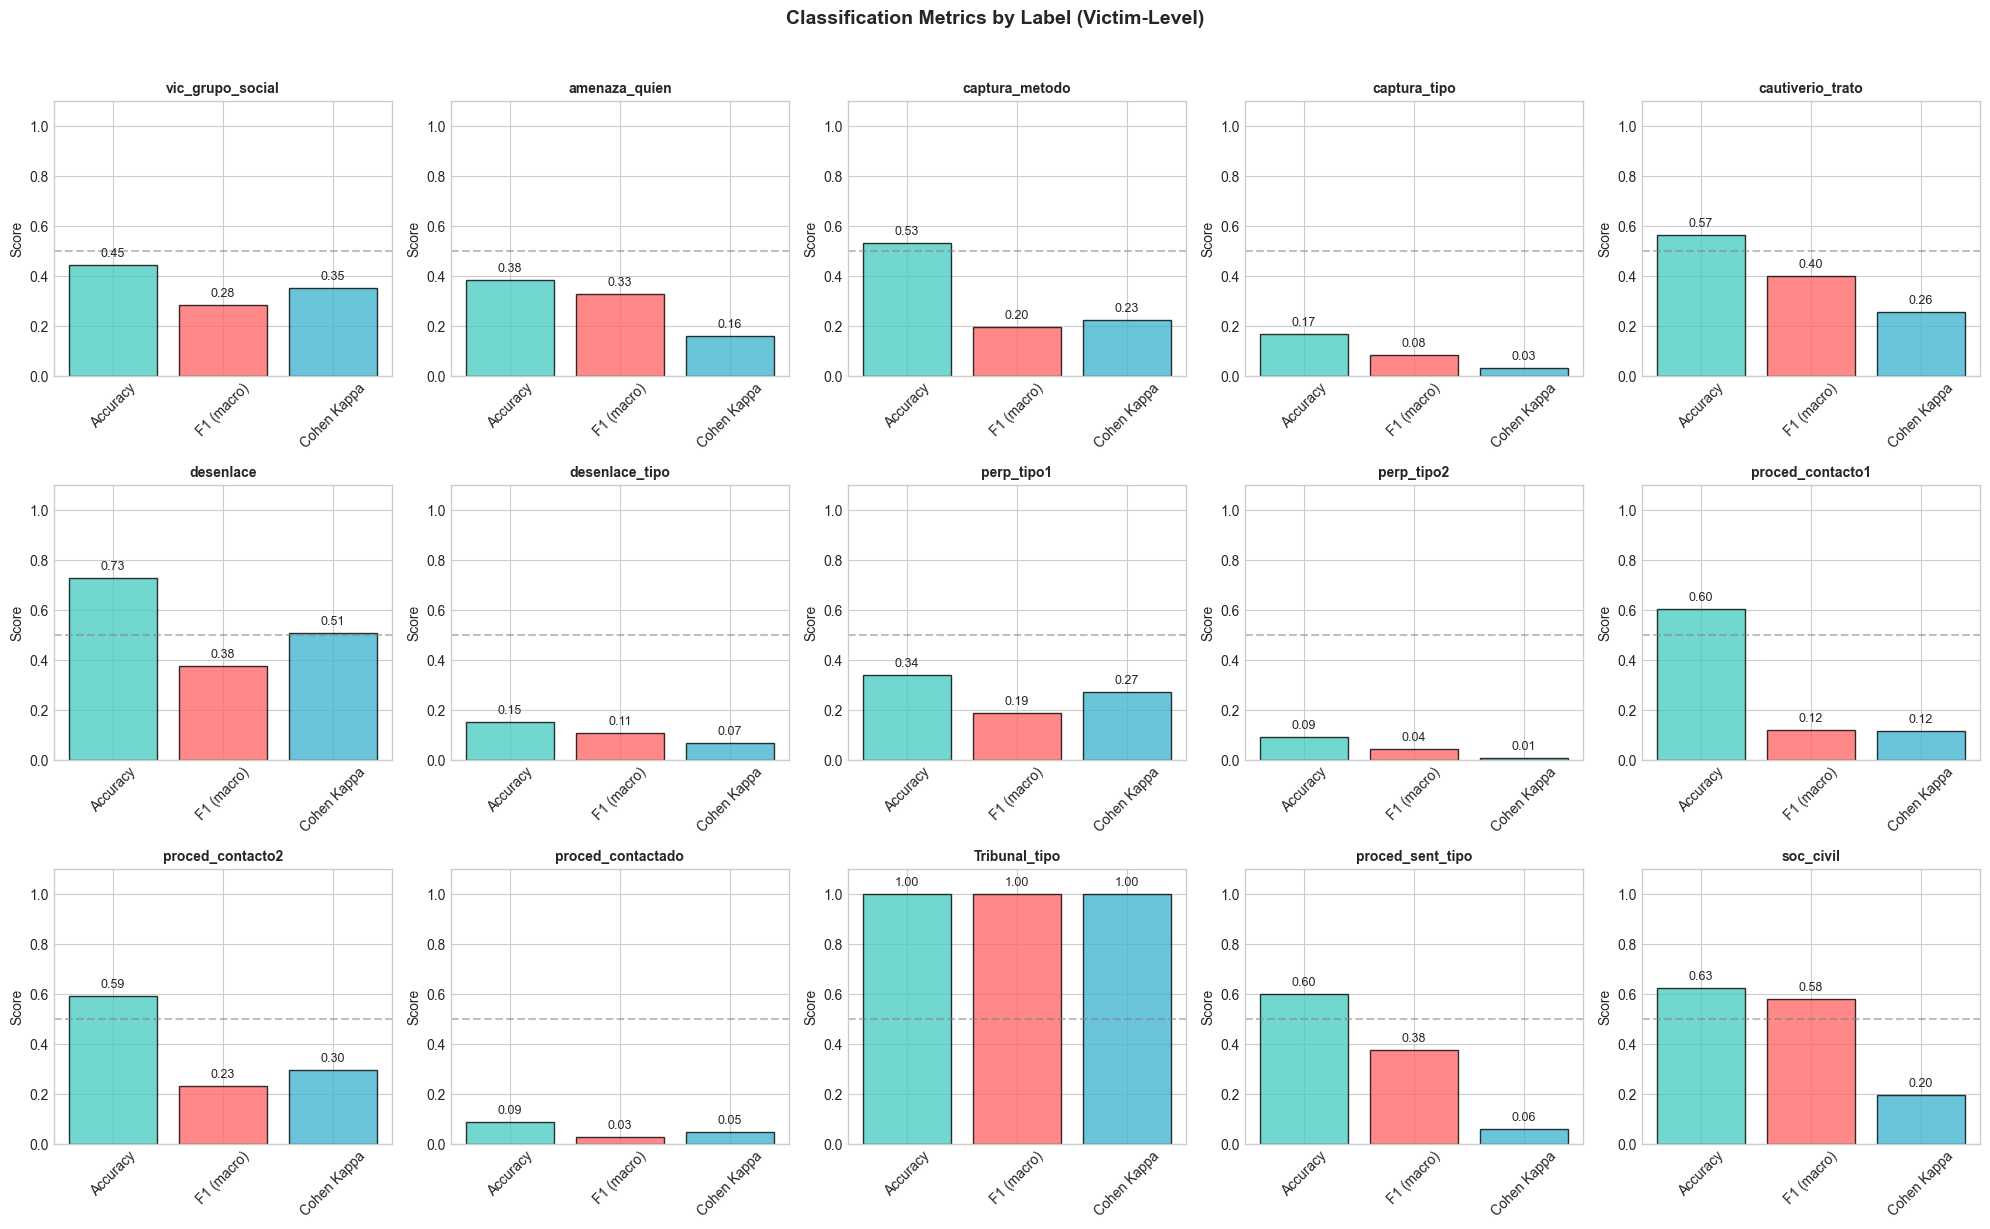

In [74]:
# Plot victim-level metrics - matrix of plots
n_labels = len(label_metrics_victim)
n_cols = 5
n_rows = (n_labels + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

metric_names = ['Accuracy', 'F1 (macro)', 'Cohen Kappa']
colors = ['#4ecdc4', '#ff6b6b', '#45b7d1']

for idx, (label_name, metrics_dict) in enumerate(label_metrics_victim.items()):
    ax = axes[idx]
    values = [metrics_dict[m] for m in metric_names]
    
    bars = ax.bar(metric_names, values, color=colors, edgecolor='black', alpha=0.8)
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylim(0, 1.1)
    ax.set_title(label_name, fontsize=10, fontweight='bold')
    ax.set_ylabel('Score')
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=45)

for idx in range(len(label_metrics_victim), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Classification Metrics by Label (Victim-Level)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/metrics_per_label_victim.png', dpi=150, bbox_inches='tight')
plt.show()


In [75]:
# Calculate difference: victim-level - source-level metrics
label_metrics_diff = {}

for label_name in label_metrics.keys():
    if label_name in label_metrics_victim:
        label_metrics_diff[label_name] = {
            'Accuracy': label_metrics_victim[label_name]['Accuracy'] - label_metrics[label_name]['Accuracy'],
            'F1 (macro)': label_metrics_victim[label_name]['F1 (macro)'] - label_metrics[label_name]['F1 (macro)'],
            'Cohen Kappa': label_metrics_victim[label_name]['Cohen Kappa'] - label_metrics[label_name]['Cohen Kappa']
        }

# Convert to DataFrame
metrics_diff_df = pd.DataFrame(label_metrics_diff).T
metrics_diff_df.columns = ['Δ Accuracy', 'Δ F1 (macro)', 'Δ Cohen Kappa']
print("Difference (Victim - Source): Positive = victim-level is better")
metrics_diff_df


Difference (Victim - Source): Positive = victim-level is better


,Δ Accuracy,Δ F1 (macro),Δ Cohen Kappa
vic_grupo_social,-0.069630,0.046429,-0.070798
amenaza_quien,0.009615,0.123984,-0.015382
captura_metodo,0.071694,-0.016459,0.043625
captura_tipo,-0.029083,-0.018761,-0.022815
cautiverio_trato,0.012586,0.158004,0.028948
desenlace,0.025741,0.040486,0.025252
desenlace_tipo,-0.068370,-0.036356,-0.047833
perp_tipo1,0.032051,0.030543,0.030594
perp_tipo2,-0.010555,-0.011373,-0.031976
proced_contacto1,0.009773,0.041870,0.025432


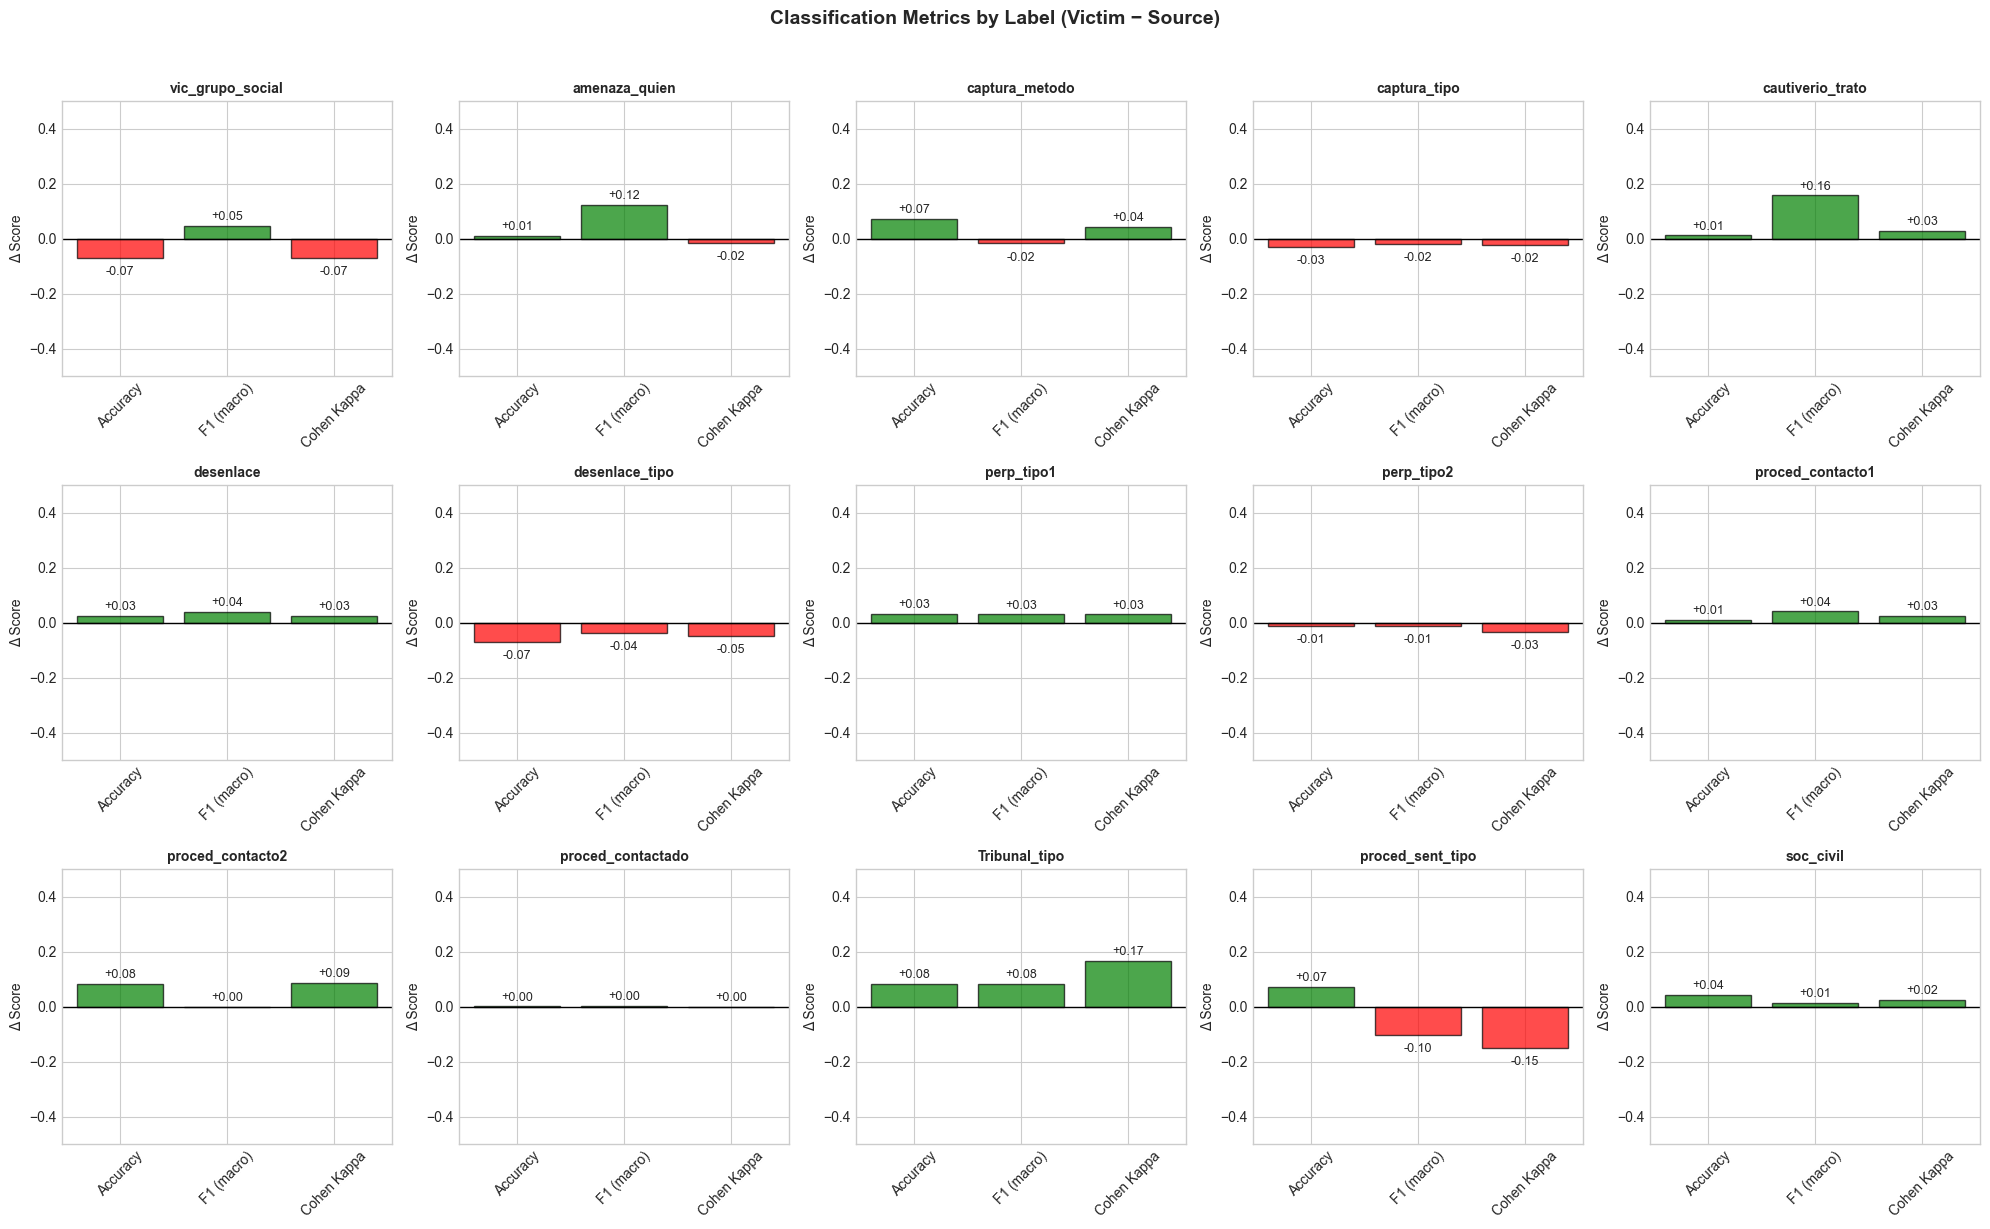

In [76]:
# Plot metric differences (Victim - Source)
n_labels = len(label_metrics_diff)
n_cols = 5
n_rows = (n_labels + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

metric_names = ['Accuracy', 'F1 (macro)', 'Cohen Kappa']
colors = ['#4ecdc4', '#ff6b6b', '#45b7d1']

for idx, (label_name, metrics_dict) in enumerate(label_metrics_diff.items()):
    ax = axes[idx]
    values = [metrics_dict[m] for m in metric_names]
    
    # Color bars based on positive/negative
    bar_colors = ['green' if v >= 0 else 'red' for v in values]
    bars = ax.bar(metric_names, values, color=bar_colors, edgecolor='black', alpha=0.7)
    
    for bar, val in zip(bars, values):
        y_pos = bar.get_height() + 0.01 if val >= 0 else bar.get_height() - 0.03
        ax.text(bar.get_x() + bar.get_width()/2, y_pos, 
                f'{val:+.2f}', ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_title(label_name, fontsize=10, fontweight='bold')
    ax.set_ylabel('Δ Score')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.tick_params(axis='x', rotation=45)

for idx in range(len(label_metrics_diff), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Classification Metrics by Label (Victim − Source)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/metrics_per_label_diff.png', dpi=150, bbox_inches='tight')
plt.show()
